# **FINAL PROJECT SOFT COMPUTING (A)**

NAMA : FEBRIYAN BIOPSA MINANDA

NIM  : 5210411203

## Import Library 

In [67]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math

import time
from itertools import chain
from typing import Any, Callable, List, Tuple, Union

import numpy as np
import random
    

## Membaca Map Provinsi Sumatera Selatan, Bengkulu, dan Lampung

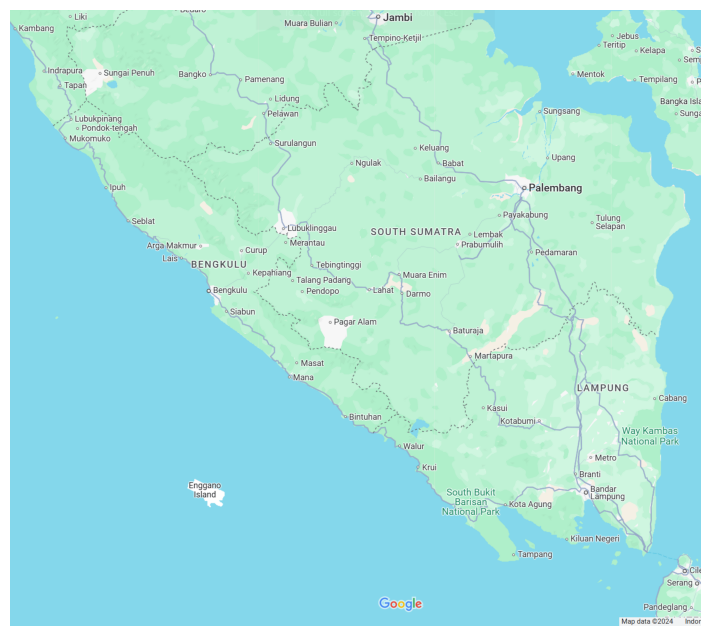

In [68]:
map = mpimg.imread("Peta Sumsel, Bengkulu, Lampung.png")

plt.figure(figsize=(12, 8))
plt.imshow(map)
plt.axis('off')
plt.show()


## Menetapkan Kabupaten/Kota Setiap Provinsi

In [69]:
def show_cities(path, w=12, h=8):
    if isinstance(path, dict):
        path = list(path.values())
    if isinstance(path[0][0], str):
        path = [item[1] for item in path]
    plt.imshow(map)
    for city_name, (x0, y0) in cities:
        plt.plot(x0, y0, "r.", markersize=10)
        plt.text(x0+15, y0+7, city_name, fontsize=9, color='black')  # Add Text
    plt.axis("off")
    fig = plt.gcf()
    fig.set_size_inches([w, h])

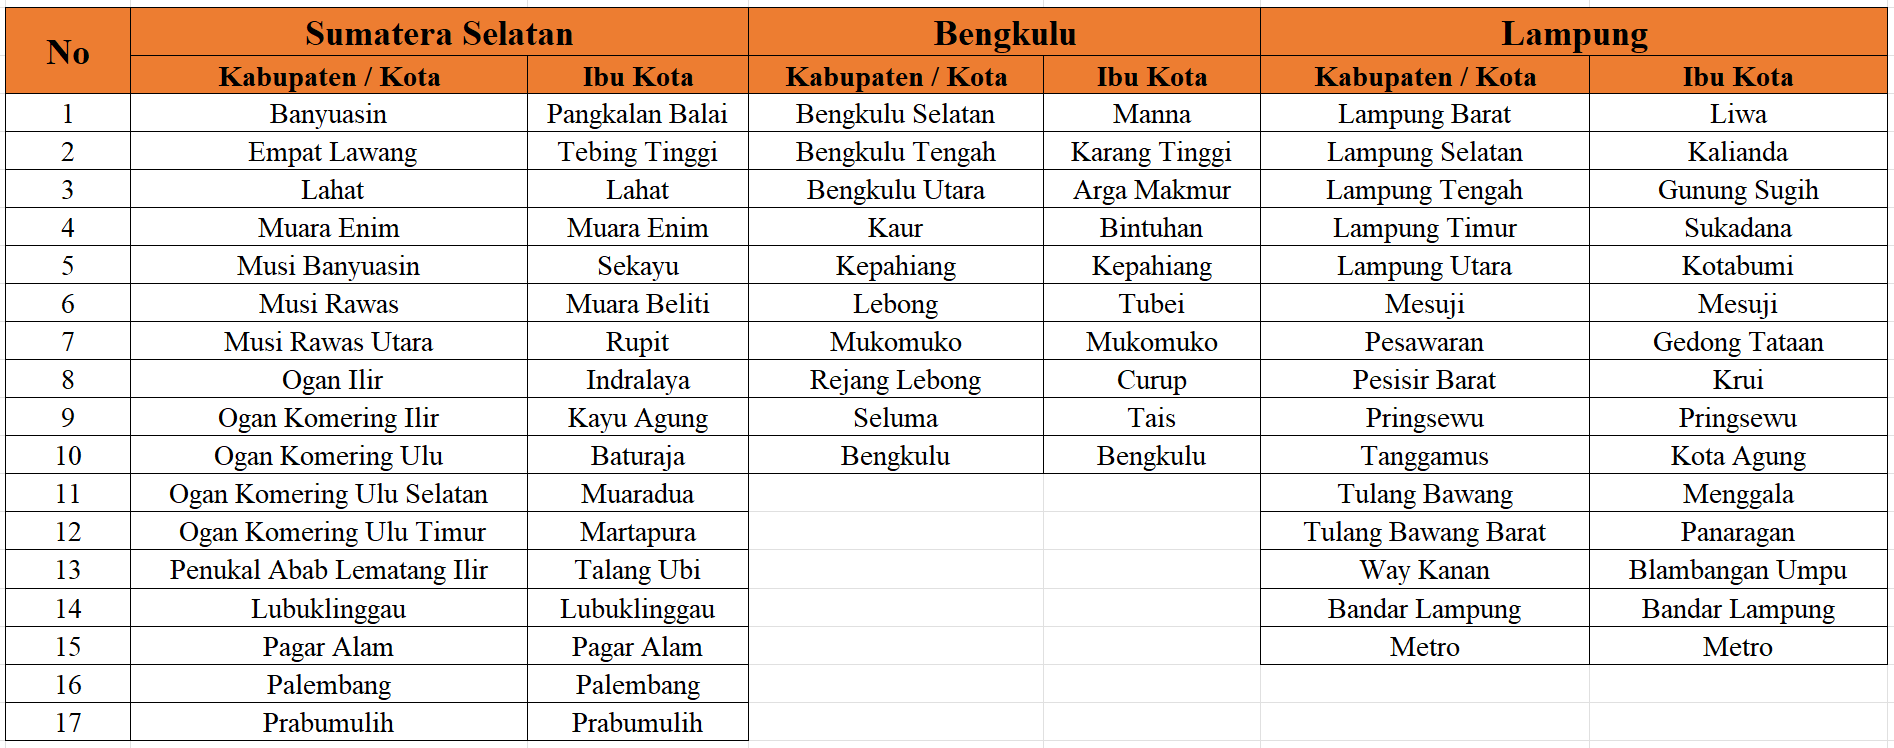

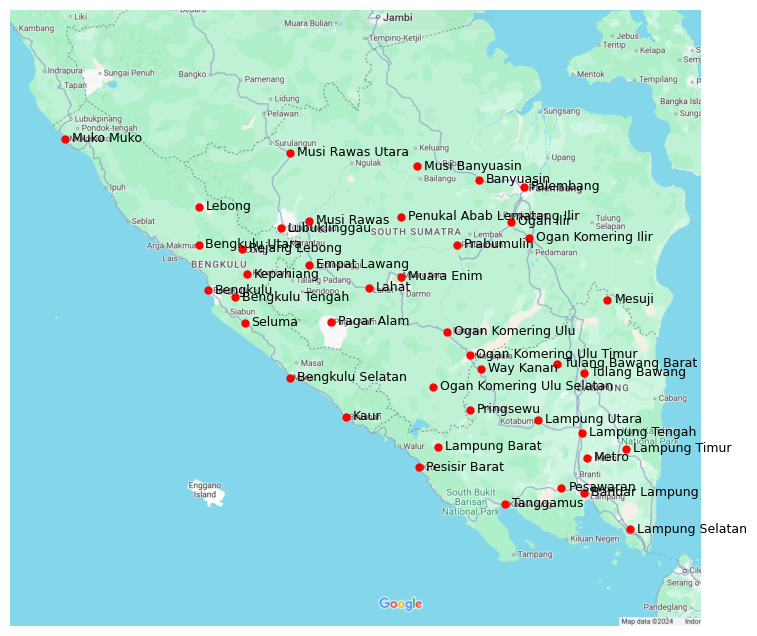

In [70]:
cities = {
    # Sumatera Selatan
    "Banyuasin": (1020, 370),
    "Empat Lawang": (650, 555),
    "Lahat": (780, 605),
    "Muara Enim": (850, 580),
    "Musi Banyuasin": (885, 340),
    "Musi Rawas": (650, 458),
    "Musi Rawas Utara": (610, 310),
    "Ogan Ilir": (1090, 460),
    "Ogan Komering Ilir": (1130, 495),
    "Ogan Komering Ulu": (950, 700),
    "Ogan Komering Ulu Selatan": (920, 820),
    "Penukal Abab Lematang Ilir": (850, 450),
    "Ogan Komering Ulu Timur": (1000, 750),
    "Lubuklinggau": (590, 475),
    "Pagar Alam": (698, 679),
    "Palembang": (1118, 385),
    "Prabumulih": (973, 510),

    # Bengkulu
    "Bengkulu Selatan": (610, 800),
    "Bengkulu Tengah": (490, 625),
    "Bengkulu Utara": (410, 510),
    "Kaur": (730, 885),
    "Kepahiang": (515, 575),
    "Lebong": (410, 428),
    "Muko Muko": (120, 280),
    "Rejang Lebong": (505, 520),
    "Seluma": (510, 680),
    "Bengkulu": (430, 610),

    # Lampung
    "Lampung Barat": (932, 950),
    "Lampung Selatan": (1350, 1130),
    "Lampung Tengah": (1245, 920),
    "Lampung Timur": (1340, 955),
    "Lampung Utara": (1150, 892),
    "Mesuji": (1300, 630),
    "Pesawaran": (1200, 1040),
    "Pesisir Barat": (890, 995),
    "Pringsewu": (1000, 870),
    "Tanggamus": (1078, 1075),
    "Tulang Bawang": (1250, 790),
    "Tulang Bawang Barat": (1190, 770),
    "Way Kanan": (1025, 780),
    "Bandar Lampung": (1250, 1050),
    "Metro": (1255, 975)
}

cities = list(sorted(cities .items()))
show_cities(map)

In [71]:
print(f"Jumlah kota: {len(cities)}")


Jumlah kota: 42


## Path

In [72]:
def show_path(path, starting_city=None, w=12, h=8, line_color='red'):
    if isinstance(path, dict):
        path = list(path.values())
    if isinstance(path[0][0], str):
        path = [item[1] for item in path]

    starting_city = starting_city or path[0]
    x, y = list(zip(*path))
    (x0, y0) = starting_city
    plt.imshow(map)
    plt.plot(x + x[:1], y + y[:1], color=line_color,
             linewidth=2)  # Set line color and thickness
    plt.axis("off")
    fig = plt.gcf()
    fig.set_size_inches([w, h])


In [73]:
def distance(xy1, xy2) -> float:
    if isinstance(xy1[0], str):
        xy1 = xy1[1]
        xy2 = xy2[1]               # if xy1 == ("Name", (x,y))
    return math.sqrt((xy1[0]-xy2[0])**2 + (xy1[1]-xy2[1])**2)


def path_distance(path) -> int:
    if isinstance(path, dict):
        path = list(path.values())            # if path == {"Name": (x,y)}
    if isinstance(path[0][0], str):
        path = [item[1] for item in path]   # if path == ("Name", (x,y))
    return int(sum(
        [distance(path[i],  path[i+1]) for i in range(len(path)-1)]
        # include cost of return journey
        + [distance(path[-1], path[0])]
    ))


Total jarak: 15618


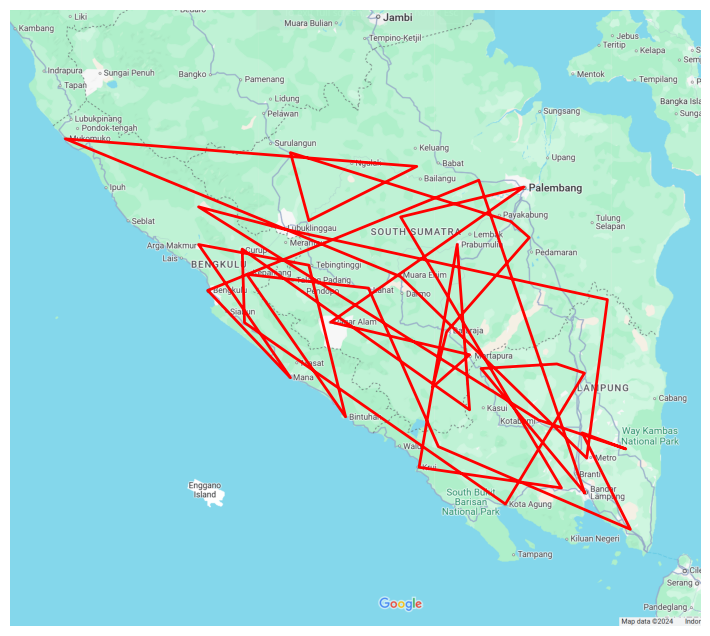

In [74]:
show_path(cities)
print("Total jarak:", path_distance(cities))

## Ant Colony Optimization

### Meet The Ant Colony

In [75]:
class AntColonySolver:
    def __init__(self,
                 cost_fn:                 Callable[[Any, Any], Union[float, int]],

                 time=0,                  # run for a fixed amount of time
                 min_time=0,              # minimum runtime
                 timeout=0,               # maximum time in seconds to run for
                 stop_factor=2,           # how many times to redouble effort after new new best path
                 min_round_trips=10,      # minimum number of round trips before stopping
                 max_round_trips=0,       # maximum number of round trips before stopping
                 min_ants=0,              # Total number of ants to use
                 max_ants=0,              # Total number of ants to use

                 # this is the bottom of the near-optimal range for numpy performance
                 ant_count=64,
                 ant_speed=1,             # how many steps do ants travel per epoch

                 distance_power=1,        # power to which distance affects pheromones
                 pheromone_power=1.25,    # power to which differences in pheromones are noticed
                 decay_power=0,           # how fast do pheromones decay
                 reward_power=0,          # relative pheromone reward based on best_path_length/path_length
                 best_path_smell=2,       # queen multiplier for pheromones upon finding a new best path
                 # amount of starting pheromones [0 defaults to `10**self.distance_power`]
                 start_smell=0,

                 verbose=False,

                 ):
        assert callable(cost_fn)
        self.cost_fn = cost_fn
        self.time = int(time)
        self.min_time = int(min_time)
        self.timeout = int(timeout)
        self.stop_factor = float(stop_factor)
        self.min_round_trips = int(min_round_trips)
        self.max_round_trips = int(max_round_trips)
        self.min_ants = int(min_ants)
        self.max_ants = int(max_ants)

        self.ant_count = int(ant_count)
        self.ant_speed = int(ant_speed)

        self.distance_power = float(distance_power)
        self.pheromone_power = float(pheromone_power)
        self.decay_power = float(decay_power)
        self.reward_power = float(reward_power)
        self.best_path_smell = float(best_path_smell)
        self.start_smell = float(start_smell or 10**self.distance_power)

        self.verbose = int(verbose)
        self._initalized = False

        if self.min_round_trips and self.max_round_trips:
            self.min_round_trips = min(
                self.min_round_trips, self.max_round_trips)
        if self.min_ants and self.max_ants:
            self.min_ants = min(self.min_ants, self.max_ants)

    def solve_initialize(
            self,
            problem_path: List[Any],
    ) -> None:
        # Cache of distances between nodes
        self.distances = {
            source: {
                dest: self.cost_fn(source, dest)
                for dest in problem_path
            }
            for source in problem_path
        }

        # Cache of distance costs between nodes - division in a tight loop is expensive
        self.distance_cost = {
            source: {
                dest: 1 / (1 + self.distances[source]
                           [dest]) ** self.distance_power
                for dest in problem_path
            }
            for source in problem_path
        }

        # This stores the pheromone trail that slowly builds up
        self.pheromones = {
            source: {
                # Encourage the ants to start exploring in all directions and furthest nodes
                dest: self.start_smell
                for dest in problem_path
            }
            for source in problem_path
        }

        # Sanitise input parameters
        if self.ant_count <= 0:
            self.ant_count = len(problem_path)
        if self.ant_speed <= 0:
            self.ant_speed = np.median(
                list(chain(*[d.values() for d in self.distances.values()]))) // 5
        self.ant_speed = int(max(1, self.ant_speed))

        # Heuristic Exports
        self.ants_used = 0
        self.epochs_used = 0
        self.round_trips = 0
        self._initalized = True

    def solve(self,
              problem_path: List[Any],
              restart=False,
              ) -> List[Tuple[int, int]]:
        if restart or not self._initalized:
            self.solve_initialize(problem_path)

        # Here come the ants!
        ants = {
            "distance":    np.zeros((self.ant_count,)).astype('int32'),
            "path":        [[problem_path[0]] for n in range(self.ant_count)],
            "remaining":   [set(problem_path[1:]) for n in range(self.ant_count)],
            "path_cost":   np.zeros((self.ant_count,)).astype('int32'),
            "round_trips": np.zeros((self.ant_count,)).astype('int32'),
        }

        best_path = None
        best_path_cost = np.inf
        best_epochs = []
        epoch = 0
        time_start = time.perf_counter()
        while True:
            epoch += 1

            # Vectorized walking of ants
            # Small optimization here, testing against `> self.ant_speed` rather than `> 0`
            #       avoids computing ants_arriving in the main part of this tight loop
            ants_travelling = (ants['distance'] > self.ant_speed)
            ants['distance'][ants_travelling] -= self.ant_speed
            if all(ants_travelling):
                continue  # skip termination checks until the next ant arrives

            # Vectorized checking of ants arriving
            ants_arriving = np.invert(ants_travelling)
            ants_arriving_index = np.where(ants_arriving)[0]
            for i in ants_arriving_index:

                # ant has arrived at next_node
                this_node = ants['path'][i][-1]
                next_node = self.next_node(ants, i)
                ants['distance'][i] = self.distances[this_node][next_node]
                ants['remaining'][i] = ants['remaining'][i] - {this_node}
                ants['path_cost'][i] = ants['path_cost'][i] + \
                    ants['distance'][i]
                ants['path'][i].append(next_node)

                # ant has returned home to the colony
                if not ants['remaining'][i] and ants['path'][i][0] == ants['path'][i][-1]:
                    self.ants_used += 1
                    self.round_trips = max(
                        self.round_trips, ants["round_trips"][i] + 1)

                    # We have found a new best path - inform the Queen
                    was_best_path = False
                    if ants['path_cost'][i] < best_path_cost:
                        was_best_path = True
                        best_path_cost = ants['path_cost'][i]
                        best_path = ants['path'][i]
                        best_epochs += [epoch]
                        if self.verbose:
                            print({
                                "path_cost":   int(ants['path_cost'][i]),
                                "ants_used":   self.ants_used,
                                "epoch":       epoch,
                                "round_trips": ants['round_trips'][i] + 1,
                                "clock":       int(time.perf_counter() - time_start),
                            })

                    # leave pheromone trail
                    # doing this only after ants arrive home improves initial exploration
                    #  * self.round_trips has the effect of decaying old pheromone trails
                    # ** self.reward_power = -3 has the effect of encouraging ants to explore longer routes
                    #                           in combination with doubling pheromone for best_path
                    reward = 1
                    if self.reward_power:
                        reward *= ((best_path_cost /
                                   ants['path_cost'][i]) ** self.reward_power)
                    if self.decay_power:
                        reward *= (self.round_trips ** self.decay_power)
                    for path_index in range(len(ants['path'][i]) - 1):
                        this_node = ants['path'][i][path_index]
                        next_node = ants['path'][i][path_index+1]
                        self.pheromones[this_node][next_node] += reward
                        self.pheromones[next_node][this_node] += reward
                        if was_best_path:
                            # Queen orders to double the number of ants following this new best path
                            self.pheromones[this_node][next_node] *= self.best_path_smell
                            self.pheromones[next_node][this_node] *= self.best_path_smell

                    # reset ant
                    ants["distance"][i] = 0
                    ants["path"][i] = [problem_path[0]]
                    ants["remaining"][i] = set(problem_path[1:])
                    ants["path_cost"][i] = 0
                    ants["round_trips"][i] += 1

            # Do we terminate?

            # Always wait for at least 1 solutions (note: 2+ solutions are not guaranteed)
            if not len(best_epochs):
                continue

            # Timer takes priority over other constraints
            if self.time or self.min_time or self.timeout:
                clock = time.perf_counter() - time_start
                if self.time:
                    if clock > self.time:
                        break
                    else:
                        continue
                if self.min_time and clock < self.min_time:
                    continue
                if self.timeout and clock > self.timeout:
                    break

            # First epoch only has start smell - question: how many epochs are required for a reasonable result?
            if self.min_round_trips and self.round_trips < self.min_round_trips:
                continue
            if self.max_round_trips and self.round_trips >= self.max_round_trips:
                break

            # This factor is most closely tied to computational power
            if self.min_ants and self.ants_used < self.min_ants:
                continue
            if self.max_ants and self.ants_used >= self.max_ants:
                break

            # Lets keep redoubling our efforts until we can't find anything more
            if self.stop_factor and epoch > (best_epochs[-1] * self.stop_factor):
                break

            # Nothing else is stopping us: Queen orders the ants to continue!
            if True:
                continue

        # We have (hopefully) found a near-optimal path, report back to the Queen
        self.epochs_used = epoch
        self.round_trips = np.max(ants["round_trips"])
        return best_path

    def next_node(self, ants, index):
        this_node = ants['path'][index][-1]

        weights = []
        weights_sum = 0
        if not ants['remaining'][index]:
            return ants['path'][index][0]  # return home
        for next_node in ants['remaining'][index]:
            if next_node == this_node:
                continue
            reward = (
                self.pheromones[this_node][next_node] ** self.pheromone_power
                # Prefer shorter paths
                * self.distance_cost[this_node][next_node]
            )
            weights.append((reward, next_node))
            weights_sum += reward

        # Pick a random path in proportion to the weight of the pheromone
        rand = random.random() * weights_sum
        for (weight, next_node) in weights:
            if rand > weight:
                rand -= weight
            else:
                break
        return next_node


def AntColonyRunner(cities, verbose=False, plot=False, label={}, algorithm=AntColonySolver, **kwargs):
    solver = algorithm(cost_fn=distance, verbose=verbose, **kwargs)
    start_time = time.perf_counter()
    result = solver.solve(cities)
    stop_time = time.perf_counter()
    if label:
        kwargs = {**label, **kwargs}

    for key in ['verbose', 'plot', 'animate', 'label', 'min_time', 'max_time']:
        if key in kwargs:
            del kwargs[key]
    print("N={:<3d} | {:5.0f} -> {:4.0f} | {:4.0f}s | ants: {:5d} | trips: {:4d} | "
          .format(len(cities), path_distance(cities), path_distance(result), (stop_time - start_time), solver.ants_used, solver.round_trips)
          + " ".join([f"{k}={v}" for k, v in kwargs.items()])
          )
    if plot:
        show_path(result)
    return result


### Solving the Travelling Salesman Problem

{'path_cost': 11760, 'ants_used': 1, 'epoch': 11217, 'round_trips': 1, 'clock': 0}
{'path_cost': 11120, 'ants_used': 65, 'epoch': 24085, 'round_trips': 2, 'clock': 0}
{'path_cost': 10195, 'ants_used': 129, 'epoch': 35246, 'round_trips': 3, 'clock': 0}
{'path_cost': 9984, 'ants_used': 132, 'epoch': 36107, 'round_trips': 3, 'clock': 0}
{'path_cost': 9558, 'ants_used': 193, 'epoch': 45539, 'round_trips': 4, 'clock': 0}
{'path_cost': 9451, 'ants_used': 194, 'epoch': 45696, 'round_trips': 4, 'clock': 0}
{'path_cost': 9438, 'ants_used': 195, 'epoch': 46076, 'round_trips': 4, 'clock': 0}
{'path_cost': 9085, 'ants_used': 207, 'epoch': 47358, 'round_trips': 4, 'clock': 0}
{'path_cost': 8850, 'ants_used': 228, 'epoch': 49258, 'round_trips': 4, 'clock': 0}
{'path_cost': 8492, 'ants_used': 237, 'epoch': 50208, 'round_trips': 4, 'clock': 0}
{'path_cost': 7794, 'ants_used': 262, 'epoch': 55115, 'round_trips': 5, 'clock': 0}
{'path_cost': 7449, 'ants_used': 290, 'epoch': 57463, 'round_trips': 5, 'clo

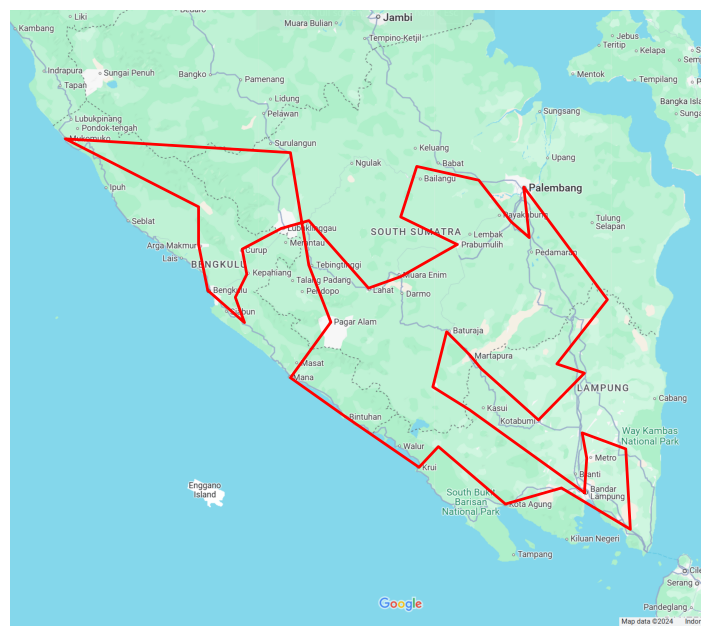

In [85]:
results = AntColonyRunner(cities, distance_power=1, verbose=True, plot=True)

In [86]:
print(f"Total distance: {path_distance(results)}")
print(" → ".join([city[0] for city in results]))

Total distance: 5844
Bandar Lampung → Metro → Lampung Tengah → Lampung Timur → Lampung Selatan → Pesawaran → Tanggamus → Lampung Barat → Pesisir Barat → Kaur → Bengkulu Selatan → Pagar Alam → Empat Lawang → Musi Rawas Utara → Muko Muko → Lebong → Bengkulu Utara → Bengkulu → Seluma → Bengkulu Tengah → Kepahiang → Rejang Lebong → Lubuklinggau → Musi Rawas → Lahat → Muara Enim → Prabumulih → Penukal Abab Lematang Ilir → Musi Banyuasin → Banyuasin → Ogan Ilir → Ogan Komering Ilir → Palembang → Mesuji → Tulang Bawang Barat → Tulang Bawang → Lampung Utara → Way Kanan → Ogan Komering Ulu Timur → Ogan Komering Ulu → Ogan Komering Ulu Selatan → Pringsewu → Pringsewu → Bandar Lampung


### Solving with Wild Ants

{'path_cost': 17556, 'ants_used': 1, 'epoch': 16688, 'round_trips': 1, 'clock': 0}
{'path_cost': 17441, 'ants_used': 132, 'epoch': 55688, 'round_trips': 3, 'clock': 0}
{'path_cost': 16985, 'ants_used': 142, 'epoch': 57262, 'round_trips': 3, 'clock': 0}
{'path_cost': 16656, 'ants_used': 150, 'epoch': 57484, 'round_trips': 3, 'clock': 0}
{'path_cost': 16484, 'ants_used': 196, 'epoch': 73612, 'round_trips': 4, 'clock': 0}
{'path_cost': 16093, 'ants_used': 257, 'epoch': 90092, 'round_trips': 5, 'clock': 0}
{'path_cost': 15926, 'ants_used': 258, 'epoch': 90527, 'round_trips': 5, 'clock': 0}
{'path_cost': 15620, 'ants_used': 331, 'epoch': 110609, 'round_trips': 6, 'clock': 0}
{'path_cost': 15577, 'ants_used': 351, 'epoch': 113186, 'round_trips': 6, 'clock': 0}
{'path_cost': 15338, 'ants_used': 392, 'epoch': 126828, 'round_trips': 7, 'clock': 0}
{'path_cost': 14999, 'ants_used': 424, 'epoch': 130841, 'round_trips': 7, 'clock': 0}
{'path_cost': 14737, 'ants_used': 456, 'epoch': 142579, 'round_

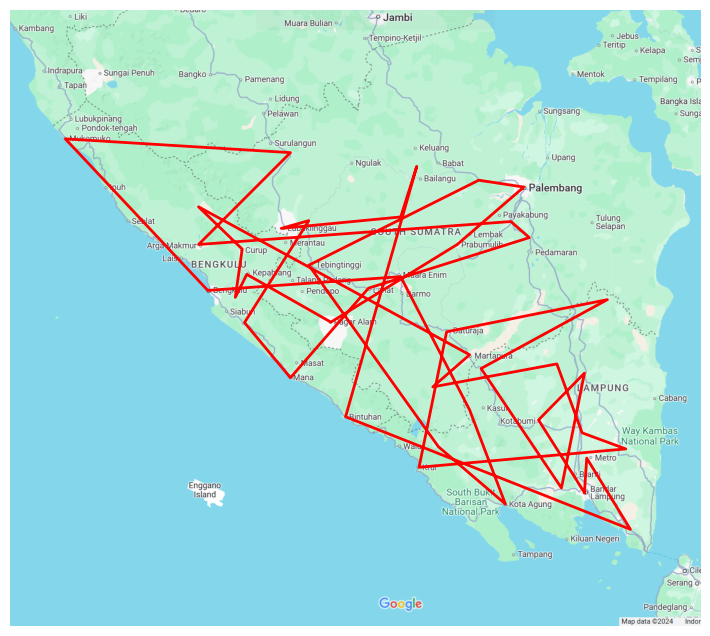

In [88]:
results = AntColonyRunner(cities, distance_power=0,stop_factor=1.25, verbose=True, plot=True)


In [89]:
print(f"Total distance: {path_distance(results)}")
print(" → ".join([city[0] for city in results]))

Total distance: 11746
Bandar Lampung → Metro → Lampung Selatan → Kaur → Musi Banyuasin → Penukal Abab Lematang Ilir → Lubuklinggau → Musi Rawas → Seluma → Bengkulu Selatan → Lahat → Ogan Komering Ilir → Ogan Ilir → Bengkulu Utara → Musi Rawas Utara → Muko Muko → Bengkulu → Muara Enim → Pringsewu → Tanggamus → Lampung Barat → Empat Lawang → Banyuasin → Palembang → Prabumulih → Pagar Alam → Kepahiang → Bengkulu Tengah → Rejang Lebong → Lebong → Ogan Komering Ulu Timur → Ogan Komering Ulu Selatan → Tulang Bawang Barat → Lampung Tengah → Lampung Timur → Pesisir Barat → Ogan Komering Ulu → Mesuji → Way Kanan → Pesawaran → Tulang Bawang → Lampung Utara → Lampung Utara → Bandar Lampung


### Hyperparameter Optimization

In [81]:
for ant_count in range(0, 16+1):
    AntColonyRunner(cities, ant_count=2**ant_count, time=60)

N=42  | 15618 -> 6597 |   60s | ants:  2083 | trips: 2083 | ant_count=1 time=60
N=42  | 15618 -> 6090 |   60s | ants:  5072 | trips: 2537 | ant_count=2 time=60
N=42  | 15618 -> 6621 |   60s | ants:  9058 | trips: 2265 | ant_count=4 time=60
N=42  | 15618 -> 6789 |   60s | ants: 15694 | trips: 1964 | ant_count=8 time=60
N=42  | 15618 -> 5850 |   60s | ants: 31604 | trips: 1977 | ant_count=16 time=60
N=42  | 15618 -> 5789 |   60s | ants: 44015 | trips: 1380 | ant_count=32 time=60
N=42  | 15618 -> 5835 |   60s | ants: 59156 | trips:  928 | ant_count=64 time=60
N=42  | 15618 -> 5722 |   60s | ants: 73942 | trips:  580 | ant_count=128 time=60
N=42  | 15618 -> 5663 |   60s | ants: 76691 | trips:  301 | ant_count=256 time=60
N=42  | 15618 -> 5309 |   60s | ants: 79640 | trips:  157 | ant_count=512 time=60
N=42  | 15618 -> 5208 |   60s | ants: 74138 | trips:   75 | ant_count=1024 time=60
N=42  | 15618 -> 5450 |   60s | ants: 72081 | trips:   36 | ant_count=2048 time=60
N=42  | 15618 -> 5341 |  